In [1]:
#IMPORTI I POSTAVKE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

#UČITAVANJE PODATAKA

df = pd.read_csv("winequality-white.csv", sep=";")
print("Shape:", df.shape)
df.head()

Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [2]:
#OSNOVNI PREGLED

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [3]:
#PROVJERA NEDOSTAJUĆIH VRIJEDNOSTI
missing = df.isna().sum()
print(missing[missing > 0])

Series([], dtype: int64)


In [4]:
#BROJ JEDINSTVENIH VRIJEDNOSTI QUALITY
df["quality"].value_counts().sort_index()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

In [5]:
#FUNKCIJE STATISTIČKIH OBRADA

def descriptive_stats(data):
    """Deskriptivna statistika za sve numeričke varijable."""
    display(data.describe().T)

def distribution_of_quality(data):
    """Frekvencijska distribucija cilj­ne varijable."""
    counts = data["quality"].value_counts().sort_index()
    display(counts)
    print("\nPostoci:")
    display((counts / len(data) * 100).round(2))

def correlation_analysis(data):
    """Korelacijska matrica i top korelacije s quality."""
    corr = data.corr(numeric_only=True)
    display(corr)

    top = corr["quality"].sort_values(ascending=False)
    print("\nTop korelacije s quality:")
    display(top)

def groupby_quality(data, feature="alcohol"):
    """Prosjek odabrane varijable po kvaliteti."""
    grouped = data.groupby("quality")[feature].mean()
    display(grouped)

def outlier_iqr(data, column):
    """Outlier analiza IQR metodom."""
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    outliers = data[(data[column] < low) | (data[column] > high)]
    print(f"{column}: {len(outliers)} outliera ({len(outliers)/len(data)*100:.2f}%)")
    return outliers

#"MENU" ZA IZBOR OBRADA

def run_analysis(choice):
    if choice == 1:
        descriptive_stats(df)
    elif choice == 2:
        distribution_of_quality(df)
    elif choice == 3:
        correlation_analysis(df)
    elif choice == 4:
        groupby_quality(df, "alcohol")
    elif choice == 5:
        outlier_iqr(df, "residual sugar")
    else:
        print("Nepoznat izbor!")

print("Izaberi analizu:")
print("1 - Deskriptivna statistika")
print("2 - Distribucija quality")
print("3 - Korelacijska analiza")
print("4 - Groupby (alcohol po quality)")
print("5 - Outlieri (residual sugar)")


Izaberi analizu:
1 - Deskriptivna statistika
2 - Distribucija quality
3 - Korelacijska analiza
4 - Groupby (alcohol po quality)
5 - Outlieri (residual sugar)


In [6]:
#INTERAKTIVNI IZBOR ANALIZE (mini "aplikacija")

choice = int(input(
    "Odaberi analizu:\n"
    "1 - Deskriptivna statistika\n"
    "2 - Distribucija quality\n"
    "3 - Korelacijska analiza\n"
    "4 - Groupby (alcohol po quality)\n"
    "5 - Outlieri (residual sugar)\n"
    "Upiši broj 1-5: "
))

run_analysis(choice)

Odaberi analizu:
1 - Deskriptivna statistika
2 - Distribucija quality
3 - Korelacijska analiza
4 - Groupby (alcohol po quality)
5 - Outlieri (residual sugar)
Upiši broj 1-5:  1


,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


In [7]:
run_analysis(1)   # Deskriptivna statistika
run_analysis(2)   # Distribucija kvalitete
run_analysis(3)   # Korelacije
run_analysis(4)   # Alkohol po kvaliteti
run_analysis(5)   # Outlieri

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64


Postoci:


quality
3     0.41
4     3.33
5    29.75
6    44.88
7    17.97
8     3.57
9     0.10
Name: count, dtype: float64

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678



Top korelacije s quality:


quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

quality
3    10.345000
4    10.152454
5     9.808840
6    10.575372
7    11.367936
8    11.636000
9    12.180000
Name: alcohol, dtype: float64

residual sugar: 7 outliera (0.14%)


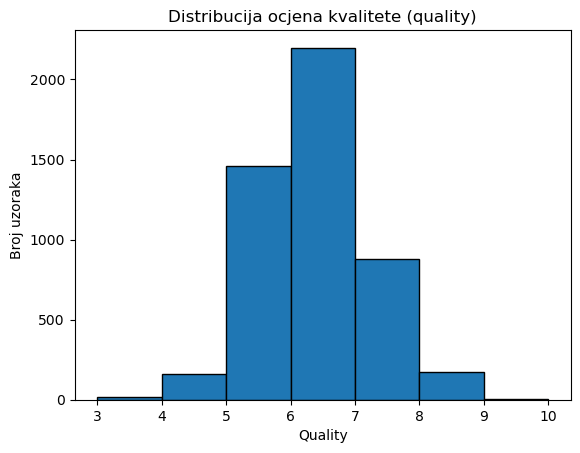

In [8]:
#GRAF 1: HISTOGRAM QUALITY

plt.figure()
plt.hist(df["quality"], bins=range(df["quality"].min(), df["quality"].max()+2), edgecolor="black")
plt.title("Distribucija ocjena kvalitete (quality)")
plt.xlabel("Quality")
plt.ylabel("Broj uzoraka")
plt.show()

<Figure size 640x480 with 0 Axes>

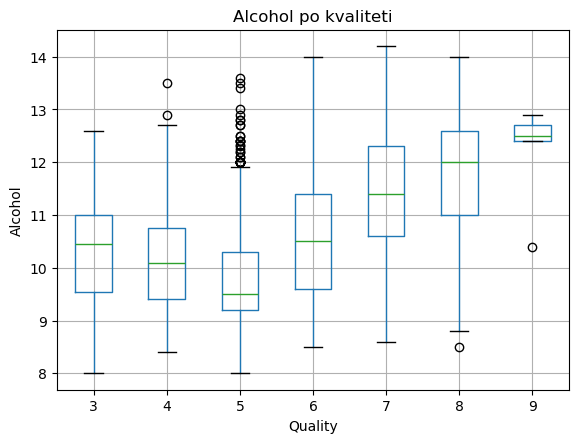

In [9]:
#8) GRAF 2: BOXPLOT ALCOHOL PO QUALITY

plt.figure()
df.boxplot(column="alcohol", by="quality")
plt.title("Alcohol po kvaliteti")
plt.suptitle("")
plt.xlabel("Quality")
plt.ylabel("Alcohol")
plt.show()

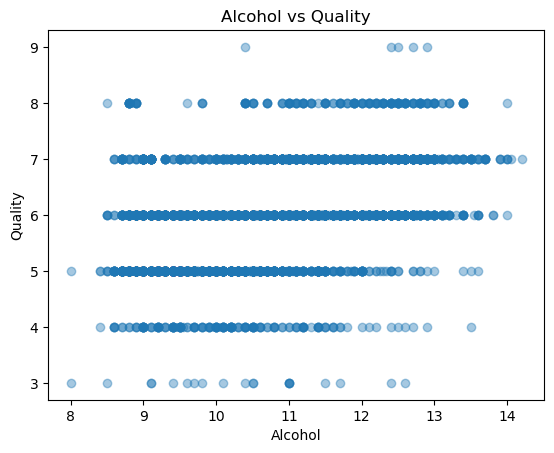

In [10]:
#GRAF 3: SCATTER ALCOHOL VS QUALITY

plt.figure()
plt.scatter(df["alcohol"], df["quality"], alpha=0.4)
plt.title("Alcohol vs Quality")
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.show()

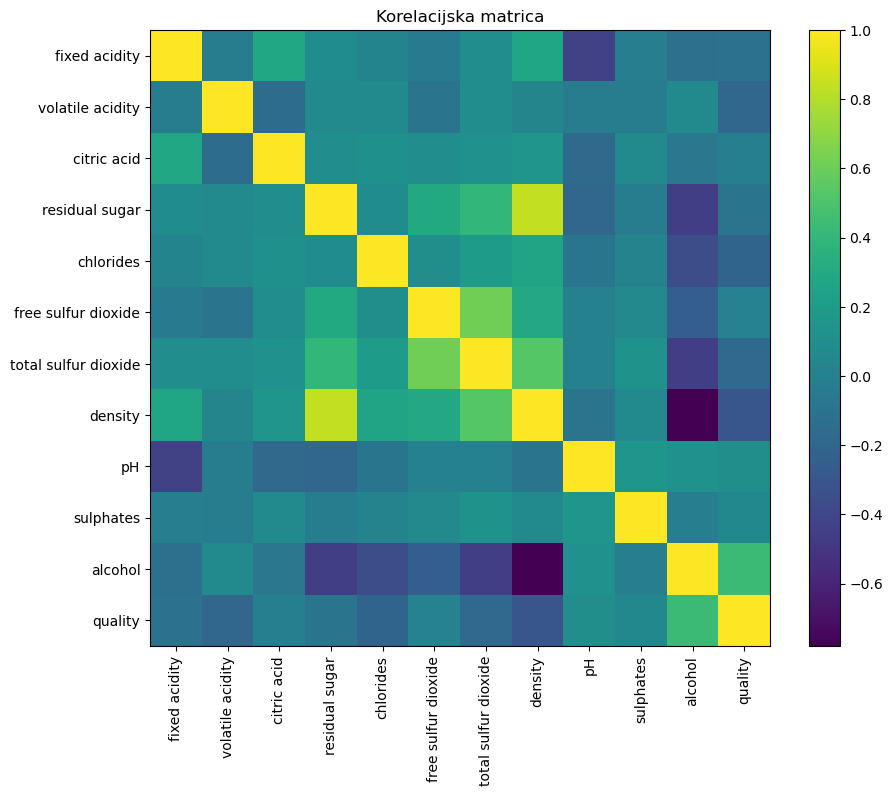

In [11]:
#GRAF 4: HEATMAP KORELACIJA (matplotlib)

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Korelacijska matrica")
plt.show()

In [12]:
#PRIPREMA X I y

X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (3918, 11) Test: (980, 11)


In [13]:
#BASELINE: LINEAR REGRESSION

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred_lr = lin_reg.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, pred_lr)

print("Linear Regression:")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R2:", r2_lr)

Linear Regression:
MAE: 0.5862665383250466
RMSE: 0.7543373063311438
R2: 0.2652750042179147


In [14]:
#RANDOM FOREST i GRIDSEARCH

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Najbolji RF parametri:", grid_rf.best_params_)

pred_rf = best_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, pred_rf)

print("\nRandom Forest:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R2:", r2_rf)

Najbolji RF parametri: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest:
MAE: 0.4172142857142857
RMSE: 0.5876840137352725
R2: 0.5540549002156483


In [ ]:
#SVR + PIPELINE + GRIDSEARCH

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

pipe_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

param_grid_svr = {
    "svr__C": [1, 10, 100],
    "svr__gamma": ["scale", 0.1, 0.01],
    "svr__epsilon": [0.1, 0.2]
}

grid_svr = GridSearchCV(
    pipe_svr,
    param_grid_svr,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_svr.fit(X_train, y_train)
best_svr = grid_svr.best_estimator_

print("Najbolji SVR parametri:", grid_svr.best_params_)

pred_svr = best_svr.predict(X_test)

mae_svr = mean_absolute_error(y_test, pred_svr)
mse_svr = mean_squared_error(y_test, pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, pred_svr)

print("\nSVR:")
print("MAE:", mae_svr)
print("RMSE:", rmse_svr)
print("R2:", r2_svr)

In [ ]:
#USPOREDBA MODELA

import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "SVR"],
    "MAE": [mae_lr, mae_rf, mae_svr],
    "RMSE": [rmse_lr, rmse_rf, rmse_svr],
    "R2": [r2_lr, r2_rf, r2_svr]
})

results

In [ ]:
#FEATURE IMPORTANCE (RF)

import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print(importances)

plt.figure()
importances.head(8).plot(kind="bar")
plt.title("Najvažnije značajke za predikciju quality (RF)")
plt.xlabel("Značajka")
plt.ylabel("Važnost")
plt.show()